In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47639 (delta 3), reused 13 (delta 0), pack-reused 47623
Receiving objects: 100% (47639/47639), 551.85 MiB | 35.59 MiB/s, done.
Resolving deltas: 100% (32802/32802), done.


In [ ]:
%cd models/research/

/content/models/research


In [ ]:
!ls

a3c_blogpost	    cvt_text	   lstm_object_detection  rebar
adversarial_text    deeplab	   marco		  seq_flow_lite
attention_ocr	    deep_speech    nst_blogpost		  setup.py
audioset	    delf	   object_detection	  slim
autoaugment	    efficient-hrl  pcl_rl		  vid2depth
cognitive_planning  lfads	   README.md


In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

Processing /content/models/research
     |████████████████████████████████| 8.7MB 168kB/s 
     |████████████████████████████████| 358kB 36.2MB/s 
     |████████████████████████████████| 849kB 46.5MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 63.8MB 128kB/s 
     |████████████████████████████████| 2.0MB 47.0MB/s 
     |████████████████████████████████| 829kB 38.6MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 153kB 49.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |████████████████████████████████| 174kB 44.3MB/s 
     |████████████████████████████████| 36.7MB 186kB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
     |████████████████████████████████| 112kB 40.7MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1599424 sha256=cc1ce3fba2d0884a218410083

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

2020-11-24 12:30:53.214341: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2020-11-24 12:30:56.118021: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-24 12:30:56.179159: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-11-24 12:30:56.179250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (71f0ae9e1adc): /proc/driver/nvidia/version does not exist
2020-11-24 12:30:56.210027: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-11-24 12:30:56.210333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15752c0 initialized for pla

In [ ]:
!pip install pycocotools

In [ ]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

### Import libraries

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

### Object Detection Modules

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

### Load the model

In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

### Load Label Map

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

### Run the inference

In [ ]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [ ]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [ ]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

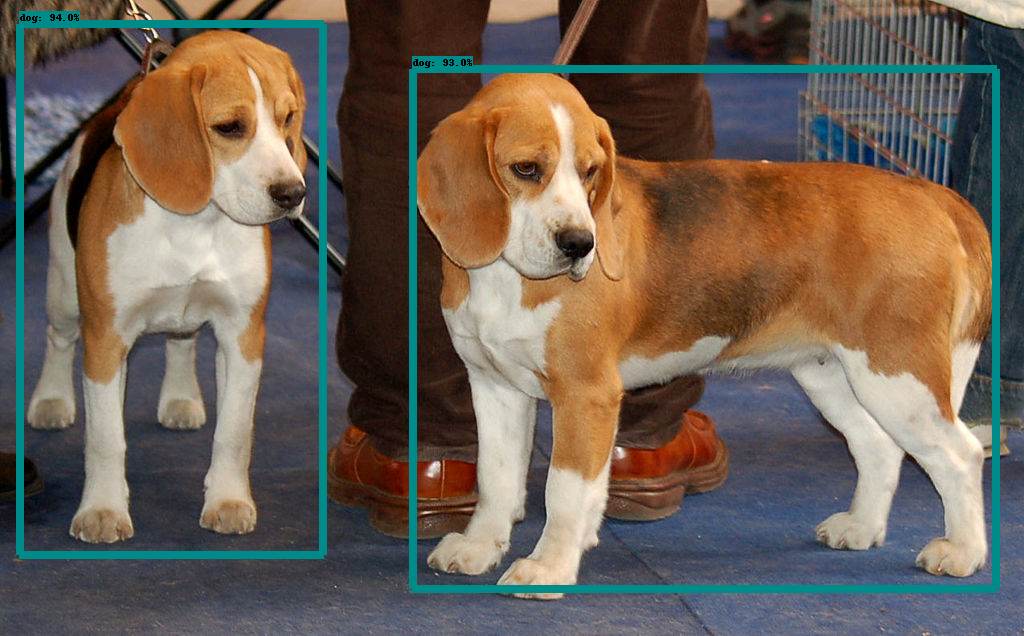

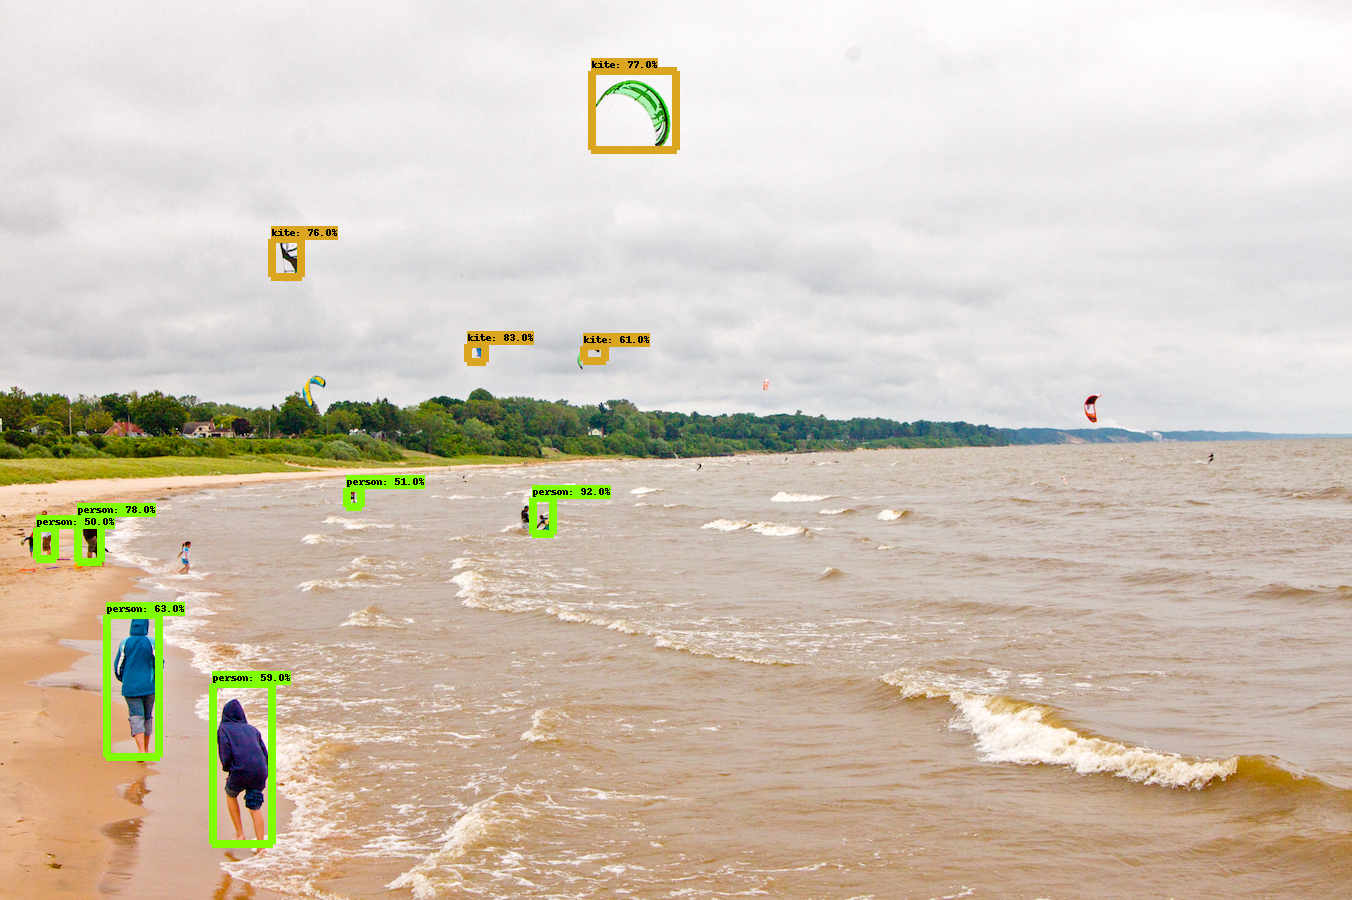

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

In [ ]:
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'
detection_model = load_model(model_name)

187932672/187925923 [==============================] - 4s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


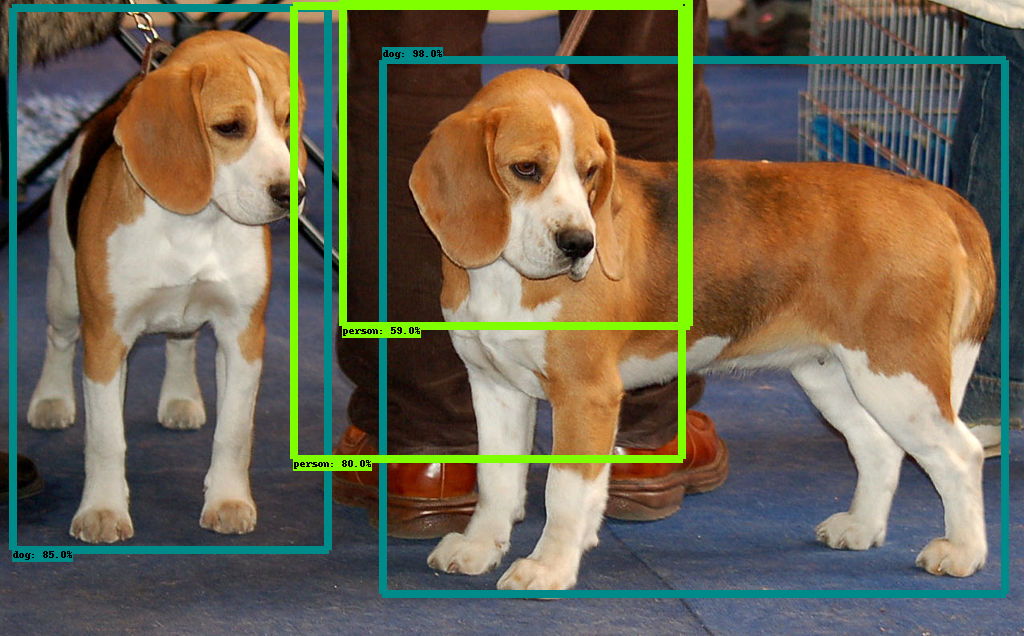

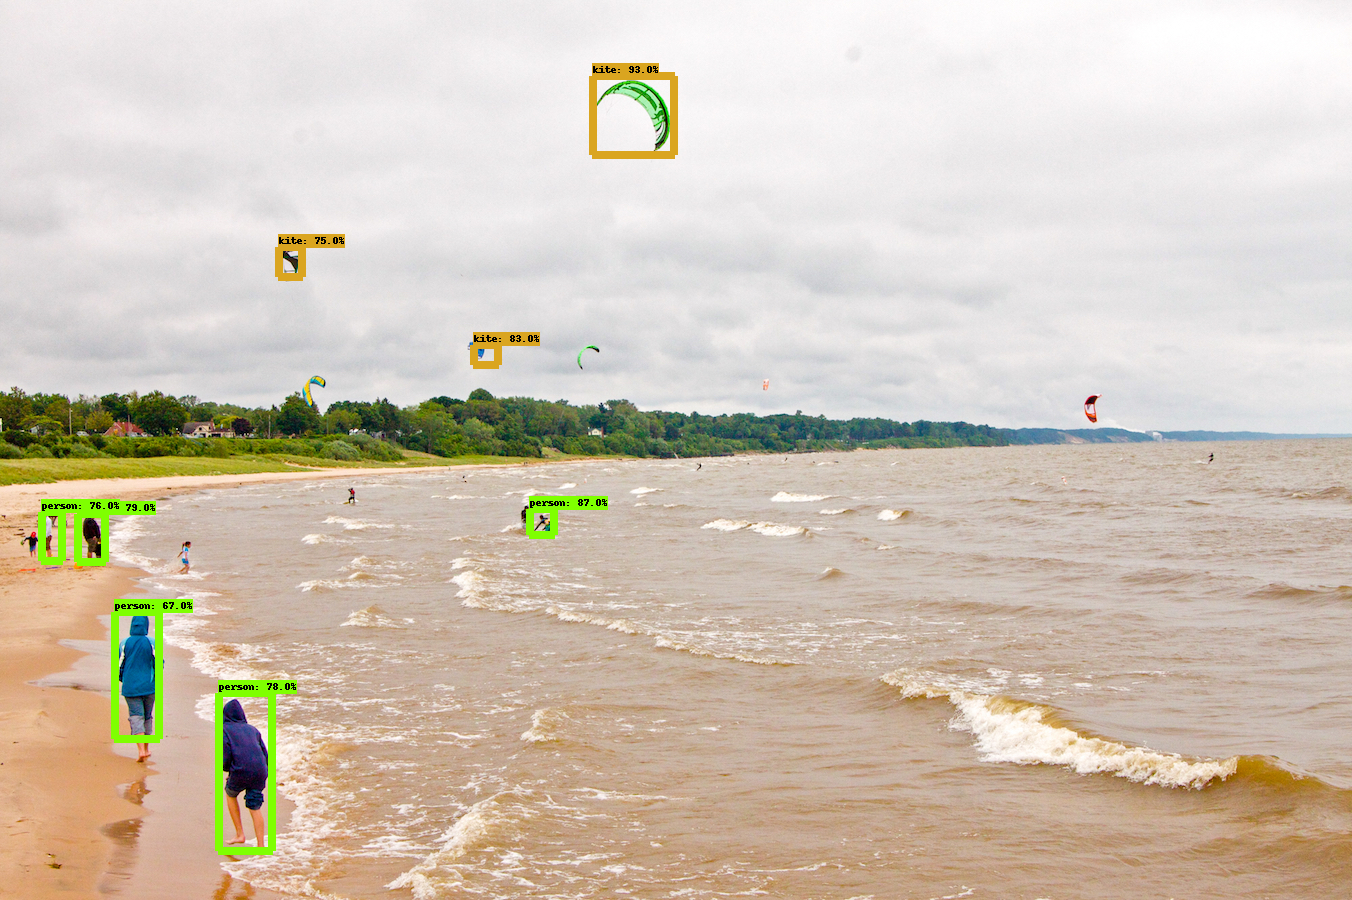

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

### Train Tensorflow SSD_v2 Model on Google's Open Image Dataset

In [ ]:
# For the fruit model included in the repo below we have 300 training images
# For faster training time, images should be resized to 300x300 and then annotated
# Images should contain the objects of interest at various scales, angles, lighting conditions, locations
# For acceptable results - mAP@0.5 of 0.9 the model was trained with batch size of 30
# and 5000 steps. this takes about 1h using 2 augmentations. 
# using 5 augmentations it takes about 2h 
num_steps = 5000  # A step means using a single batch of data. larger batch, less steps required
#Number of evaluation steps.
num_eval_steps = 50
#Batch size 24 is a setting that generally works well. can be changed higher or lower 
MODELS_CONFIG = {
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 30
    }
}
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	models	sample_data


In [ ]:
repo_url = 'https://github.com/GotG/object_detection_demo_flow'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content/models/research
Cloning into 'object_detection_demo_flow'...
remote: Enumerating objects: 3035, done.
remote: Total 3035 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3035/3035), 229.08 MiB | 33.50 MiB/s, done.
Resolving deltas: 100% (1375/1375), done.
Checking out files: 100% (2796/2796), done.
/content/object_detection_demo_flow
Already up to date.


In [ ]:
!ls data/images/train/

apple_10.jpg  apple_55.jpg   banana_32.jpg  banana_76.jpg  orange_32.jpg
apple_10.xml  apple_55.xml   banana_32.xml  banana_76.xml  orange_32.xml
apple_11.jpg  apple_56.jpg   banana_33.jpg  banana_7.jpg   orange_33.jpg
apple_11.xml  apple_56.xml   banana_33.xml  banana_7.xml   orange_33.xml
apple_12.jpg  apple_57.jpg   banana_34.jpg  banana_8.jpg   orange_34.jpg
apple_12.xml  apple_57.xml   banana_34.xml  banana_8.xml   orange_34.xml
apple_13.jpg  apple_58.jpg   banana_35.jpg  banana_9.jpg   orange_35.jpg
apple_13.xml  apple_58.xml   banana_35.xml  banana_9.xml   orange_35.xml
apple_14.jpg  apple_59.jpg   banana_36.jpg  mixed_10.jpg   orange_36.jpg
apple_14.xml  apple_59.xml   banana_36.xml  mixed_10.xml   orange_36.xml
apple_15.jpg  apple_5.jpg    banana_37.jpg  mixed_11.jpg   orange_37.jpg
apple_15.xml  apple_5.xml    banana_37.xml  mixed_11.xml   orange_37.xml
apple_16.jpg  apple_60.jpg   banana_38.jpg  mixed_12.jpg   orange_38.jpg
apple_16.xml  apple_60.xml   banana_38.xml  mixed_1

In [ ]:
#training folder
!cp -r /content/object_detection_demo_flow/data/images/train /content/gdrive/MyDrive/Tensorflow_Object_Detection/Images/
#testing folder
!cp -r /content/object_detection_demo_flow/data/images/test /content/gdrive/MyDrive/Tensorflow_Object_Detection/Images/
#final testing folder
!cp -r /content/object_detection_demo_flow/data/images/final_test /content/gdrive/MyDrive/Tensorflow_Object_Detection/Images/